In [1]:
from pathlib import Path
from tqdm import tqdm
from einops import rearrange
from fdiff.utils.fourier import dft

import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

DATA_FILEPATH = Path.cwd() / "../data/droughts/train_timeseries/"

In [2]:
# Load data
df = pd.read_csv(DATA_FILEPATH / "train_timeseries.csv")
df.head()

   

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [3]:
# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"])
df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [15]:
start_time = pd.to_datetime("2010-01-01")
end_time = pd.to_datetime("2012-01-01")

# Remove entries that are not in the inderval
df = df[(df["date"] >= start_time) & (df["date"] < end_time)]    
df.head()    

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
3653,1001,2010-01-01,0.7,100.81,4.15,3.81,1.11,1.13,7.96,-2.17,...,3.80,3.04,4.66,1.91,2.75,5.46,7.35,3.52,3.83,NaN
3654,1001,2010-01-02,0.0,101.12,2.45,-1.94,-5.62,-5.55,3.68,-5.08,...,-1.87,2.52,3.81,1.79,2.02,4.83,5.86,3.96,1.91,NaN
3655,1001,2010-01-03,0.0,100.95,2.09,-2.21,-7.57,-7.41,3.46,-5.09,...,-2.10,2.24,2.95,1.71,1.24,4.21,6.13,3.16,2.97,NaN
3656,1001,2010-01-04,0.0,100.93,1.92,-3.24,-8.57,-8.39,0.50,-5.68,...,-3.12,2.70,3.66,2.02,1.63,4.70,5.61,4.19,1.42,NaN
3657,1001,2010-01-05,0.0,101.08,1.90,-4.02,-8.69,-8.53,1.67,-7.80,...,-3.89,2.62,3.51,1.94,1.57,4.76,5.73,3.95,1.78,0.0


In [17]:
df.groupby("fips")["date"].nunique().value_counts()

date
730    3108
Name: count, dtype: int64

In [21]:
# Drop columns with missing values
df = df.dropna(axis=1)

In [22]:
df_pivot = df.pivot_table(index="fips", columns="date")
df_pivot.head()

PRECTOT                                                         \
date 2010-01-01 2010-01-02 2010-01-03 2010-01-04 2010-01-05 2010-01-06   
fips                                                                     
1001       0.70        0.0        0.0        0.0        0.0        0.0   
1003       1.05        0.0        0.0        0.0        0.0        0.0   
1005       0.85        0.0        0.0        0.0        0.0        0.0   
1007       0.83        0.0        0.0        0.0        0.0        0.0   
1009       0.36        0.0        0.0        0.0        0.0        0.0   

                                                  ... WS50M_RANGE             \
date 2010-01-07 2010-01-08 2010-01-09 2010-01-10  ...  2011-12-22 2011-12-23   
fips                                              ...                          
1001       2.65       0.00        0.0        0.0  ...        5.87       2.03   
1003       5.29       0.10        0.0        0.0  ...        4.49       0.97   
1005       1.62       0.31        0.0        0.0  ...        3.88       1.44   
1007       1.70       0.00        0.0        0.0  ...        5.76       2.29   
1009       0.37       0.00        0.0        0.0  ...        5.78       1.72   

                                                                        \
date 2011-12-24 2011-12-25 2011-12-26 2011-12-27 2011-12-28 2011-12-29   
fips                                                                     
1001       2.81       2.02       5.47       3.42       3.36       4.02   
1003       1.92       4.36       2.60       4.66       4.62       3.04   
1005       3.10       2.97       3.99       4.56       3.15       5.18   
1007       2.67       3.15       5.27       2.70       3.87       4.01   
1009       2.85       5.14       6.36       3.53       3.90       4.02   

                            
date 2011-12-30 2011-12-31  
fips                        
1001       4.09       6.26  
1003       4.06       5.65  
1005       2.79       4.52  
1007       2.92       6.42  
1009       2.26       7.10  

[5 rows x 13140 columns]

In [26]:
# Create a tensor of shape (num_stocks, num_days, num_features) from df
X = torch.tensor(df_pivot.values, dtype=torch.float32)
X = rearrange(X, "fips (feature day) -> fips day feature", day=730)
X.shape

torch.Size([3108, 730, 18])

In [27]:
for ex in range(5):
    print(X[ex, :, 0:5])

tensor([[  0.7000, 100.8100,   4.1500,   3.8100,   1.1100],
        [  0.0000, 101.1200,   2.4500,  -1.9400,  -5.6200],
        [  0.0000, 100.9500,   2.0900,  -2.2100,  -7.5700],
        ...,
        [  0.0000, 100.3100,   5.1400,   6.3400,   4.1100],
        [  0.0000, 100.1200,   7.8800,  11.2000,  10.2300],
        [  0.0000, 100.4700,   6.3800,  10.3100,   7.2600]])
tensor([[ 1.0500e+00,  1.0189e+02,  5.2100e+00,  6.9500e+00,  4.4200e+00],
        [ 0.0000e+00,  1.0219e+02,  3.7000e+00,  3.0600e+00, -2.7000e-01],
        [ 0.0000e+00,  1.0203e+02,  2.9000e+00,  1.0600e+00, -3.5900e+00],
        ...,
        [ 7.0000e-02,  1.0142e+02,  6.7700e+00,  1.2030e+01,  8.0800e+00],
        [ 9.0000e-02,  1.0130e+02,  9.5500e+00,  1.5210e+01,  1.3420e+01],
        [ 4.0000e-02,  1.0160e+02,  9.7500e+00,  1.5140e+01,  1.3760e+01]])
tensor([[ 8.5000e-01,  1.0078e+02,  4.7600e+00,  5.5200e+00,  3.0300e+00],
        [ 0.0000e+00,  1.0114e+02,  2.8200e+00, -3.0000e-01, -3.8500e+00],
        [ 0.

In [28]:
train_ratio = 0.9
num_train = int(train_ratio * len(X))
perm_idx = torch.randperm(len(X))
train_examples, test_examples = perm_idx[:num_train], perm_idx[num_train:]
X_train, X_test = X[train_examples], X[test_examples]
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: torch.Size([2797, 730, 18])
Test set shape: torch.Size([311, 730, 18])


/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

Text(0, 0.5, 'Singular value')

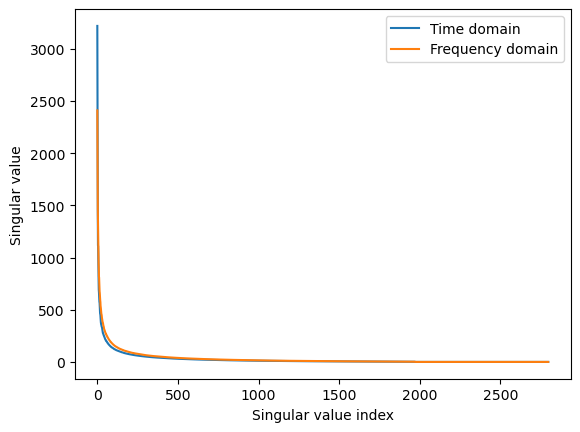

In [36]:
import matplotlib.pyplot as plt

X_norm = (X_train - X_train.mean(dim=0, keepdim=True)) / X_train.std(dim=0, keepdim=True)
X_dft = dft(X_train)
X_norm_dft = (X_dft - X_dft.mean(dim=0, keepdim=True)) / X_dft.std(dim=0, keepdim=True)

sns.lineplot(torch.svd(X_norm.flatten(start_dim=1))[1], label="Time domain")
sns.lineplot(torch.svd(X_norm_dft.flatten(start_dim=1))[1], label="Frequency domain")
plt.legend()
plt.xlabel("Singular value index")
plt.ylabel("Singular value")

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


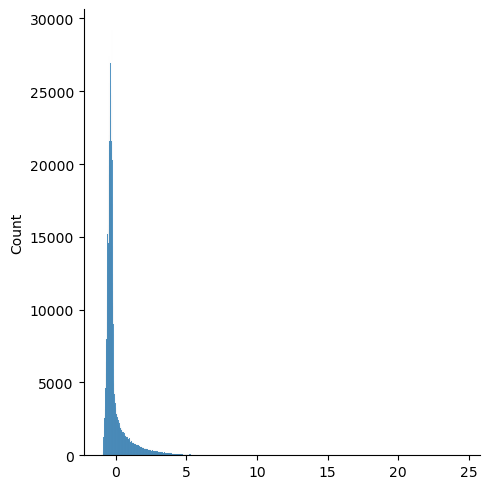

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


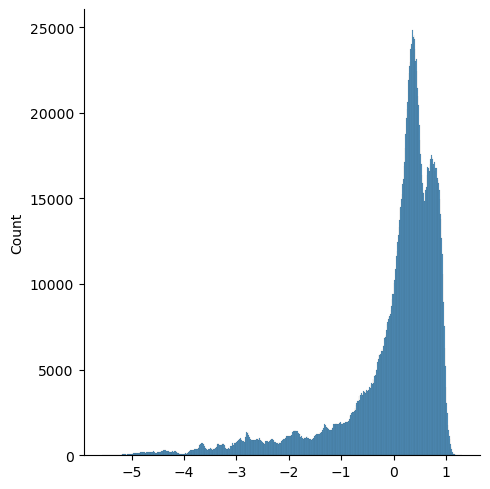

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


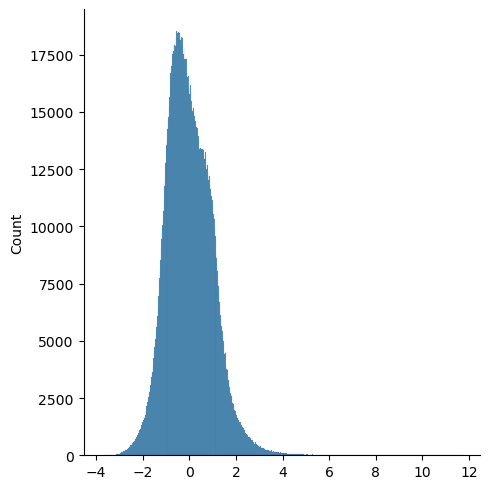

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


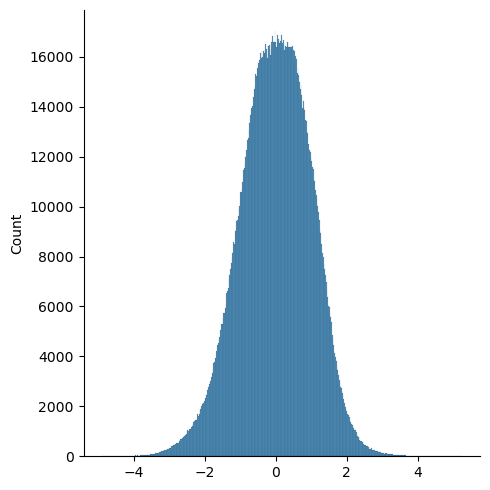

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


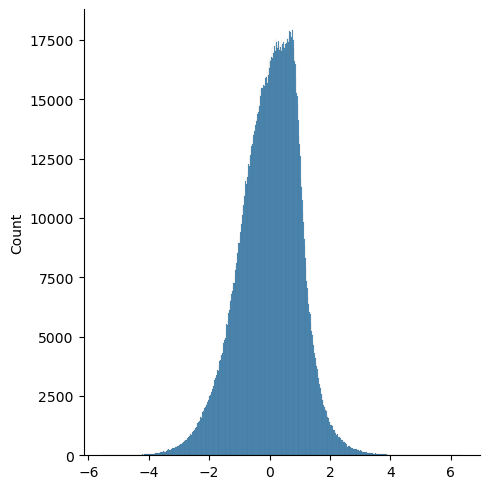

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


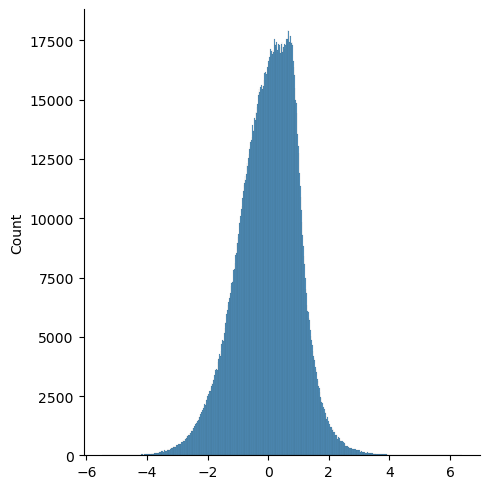

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


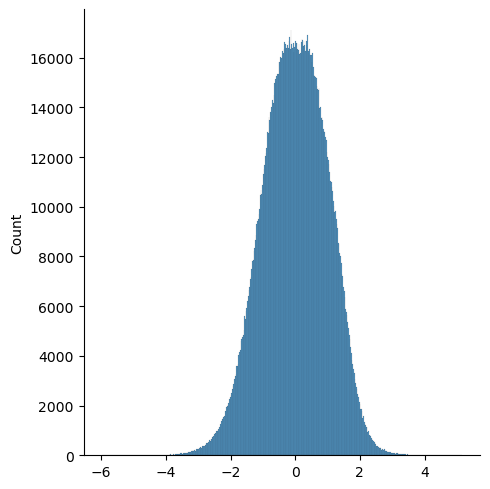

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


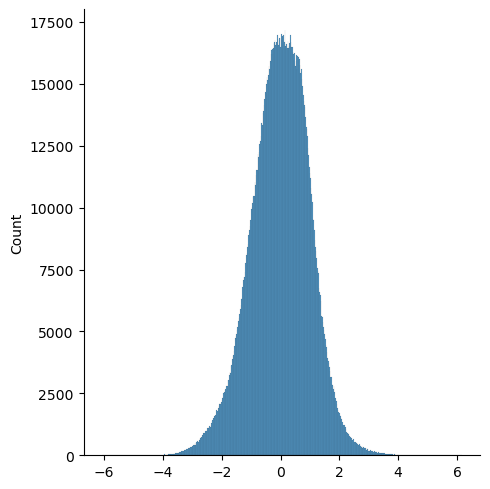

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


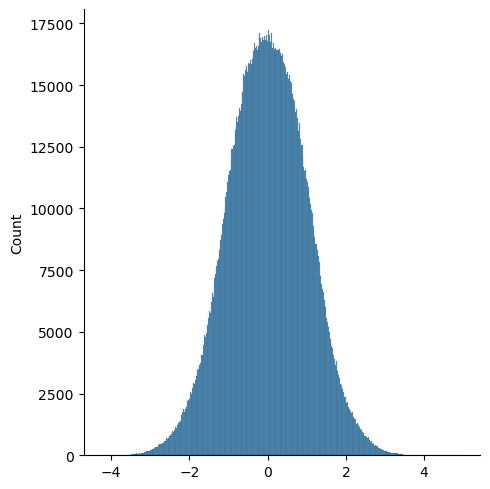

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


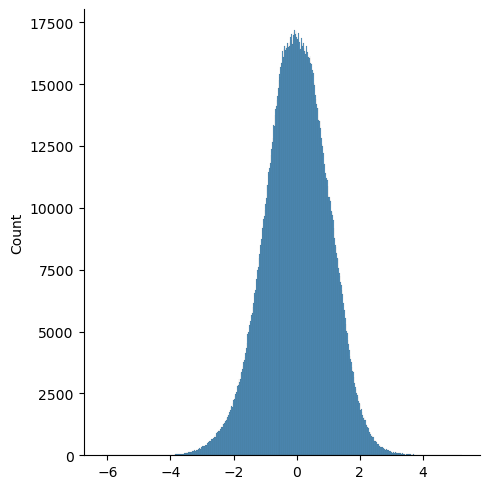

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


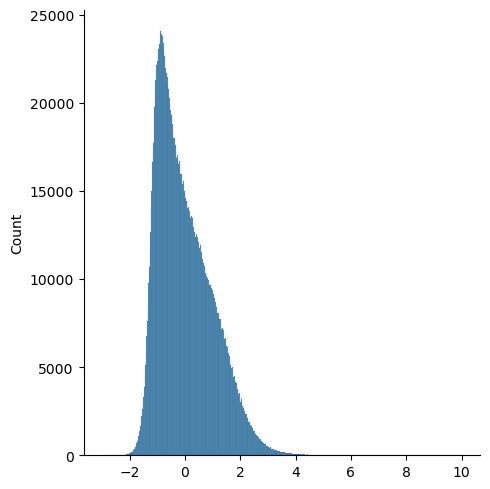

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


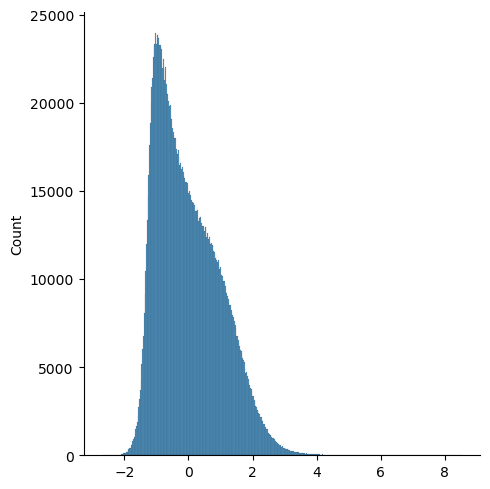

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


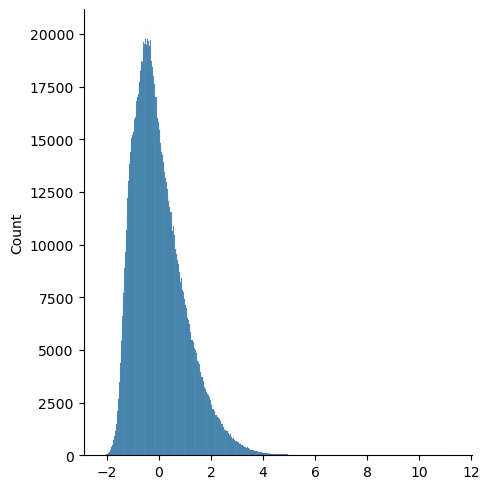

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


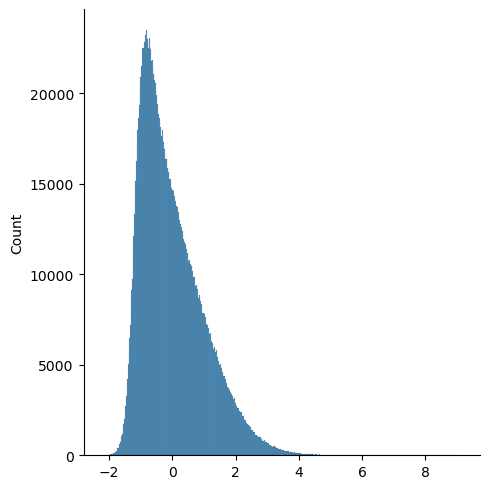

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


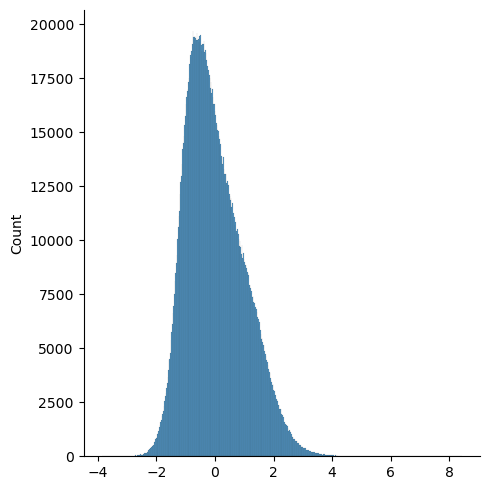

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


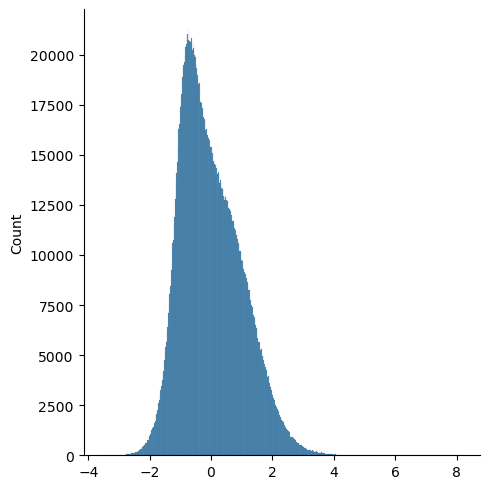

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


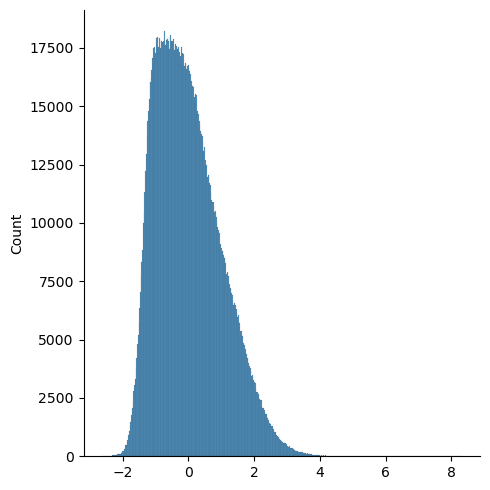

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


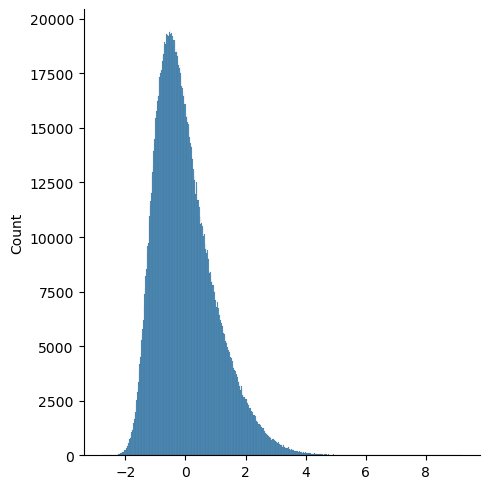

In [38]:
for i in range(18):
    sns.displot(X_norm[:, :, i].flatten())
    plt.show()